In [ ]:
import pandas as pd
import geopandas as gpd
import duckdb

# https://citibikenyc.com/system-data
# https://s3.amazonaws.com/tripdata/index.html

In [ ]:
duckdb.load_extension('spatial')
duckdb.load_extension('h3')
# duckdb.load_extension('zipfs')

In [78]:
H3_RES = 9

duckdb.sql(
    f"""
    SELECT
        ride_id,
        h3_latlng_to_cell(start_lat, start_lng, {H3_RES}) as start_h3,
        h3_latlng_to_cell(end_lat, end_lng, {H3_RES}) as end_h3,
        CASE
            WHEN HOUR(started_at) BETWEEN 6 and 10 THEN 'morning'
            WHEN HOUR(started_at) BETWEEN 16 and 20 THEN 'afternoon'
        END as day_part
    FROM read_csv('/Users/raczeq/Downloads/202401-citibike-tripdata/*.csv', sample_size=-1)
    WHERE HOUR(started_at) BETWEEN 6 and 10 OR HOUR(started_at) BETWEEN 16 and 20
    """
).to_parquet("parsed_nyc_bike_trips.parquet")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [79]:
df = duckdb.read_parquet("parsed_nyc_bike_trips.parquet").to_df()
df

ride_id            start_h3              end_h3   day_part
0        0403D0B3FC9CA77D  617733123962306559  617733123963617279  afternoon
1        84A995BFD98030D4  617733122618294271  617733123819962367  afternoon
2        7BBEAD4F2B535813  617733122618556415  617733123820748799  afternoon
3        296A378A5C42028D  617733122618294271  617733123819962367  afternoon
4        9A891F9C924C240F  617733151028412415  617733151031295999    morning
...                   ...                 ...                 ...        ...
1125825  B1996067E9C2332A  617733151036538879  617733151029198847    morning
1125826  1127EF5144354DCE  617733123783524351  617733123786407935    morning
1125827  E3DF97DCE1294357  617733123783524351  617733123786407935  afternoon
1125828  31E70D62CE26D54B  617733151092375551  617733123803185151  afternoon
1125829  56F2D840FAC54625  617733151088443391  617733123803185151  afternoon

[1125830 rows x 4 columns]

In [80]:
morning_starts = (
    df[df["day_part"] == "morning"]["start_h3"]
    .value_counts()
    .rename("morning_starts")
    .reset_index()
    .rename(columns={"start_h3": "h3"})
)
morning_ends = (
    df[df["day_part"] == "morning"]["end_h3"]
    .value_counts()
    .rename("morning_ends")
    .reset_index()
    .rename(columns={"end_h3": "h3"})
)
afternoon_starts = (
    df[df["day_part"] == "afternoon"]["start_h3"]
    .value_counts()
    .rename("afternoon_starts")
    .reset_index()
    .rename(columns={"start_h3": "h3"})
)
afternoon_ends = (
    df[df["day_part"] == "afternoon"]["end_h3"]
    .value_counts()
    .rename("afternoon_ends")
    .reset_index()
    .rename(columns={"end_h3": "h3"})
)
afternoon_ends

h3  afternoon_ends
0     617733123811311615            5635
1     617733151088181247            4482
2     617733123803185151            4207
3     617733123820748799            3947
4     617733150971789311            3873
...                  ...             ...
1493  617733150418141183               1
1494  617733123856400383               1
1495  617733150934302719               1
1496  617733150936924159               1
1497  617733150938497023               1

[1498 rows x 2 columns]

In [81]:
from srai.h3 import h3_to_geoseries

In [82]:
h3_with_trips = (
    morning_starts.merge(morning_ends, on="h3", how="outer")
    .merge(afternoon_starts, on="h3", how="outer")
    .merge(afternoon_ends, on="h3", how="outer")
    .fillna(0)
)
h3_with_trips = gpd.GeoDataFrame(
    h3_with_trips,
    geometry=h3_to_geoseries(h3_with_trips["h3"].to_list()),
)
h3_with_trips

h3  morning_starts  morning_ends  afternoon_starts  \
0     617733120577503231              58            15                24   
1     617733120577765375              18             5                32   
2     617733120578027519               8            26                24   
3     617733120578289663             129            61               103   
4     617733120578551807              50            14                72   
...                  ...             ...           ...               ...   
1496  617733152329433087              86            88                73   
1497  617733152329695231              70            94               147   
1498  617733152329957375              51            49                38   
1499  617733152333627391             144           132               206   
1500  617733152333889535              85           132               179   

      afternoon_ends                                           geometry  
0                 38  POLYGON ((-73.88768 40.876, -73.88979 40.87506...  
1                 50  POLYGON ((-73.88543 40.87341, -73.88755 40.872...  
2                 21  POLYGON ((-73.89196 40.87589, -73.89407 40.874...  
3                108  POLYGON ((-73.88972 40.8733, -73.89183 40.8723...  
4                 80  POLYGON ((-73.88563 40.8787, -73.88774 40.8777...  
...              ...                                                ...  
1496              59  POLYGON ((-74.00425 40.67719, -74.00635 40.676...  
1497              88  POLYGON ((-74.00201 40.67461, -74.00411 40.673...  
1498              45  POLYGON ((-74.00852 40.67707, -74.01062 40.676...  
1499             197  POLYGON ((-74.01503 40.67954, -74.01713 40.678...  
1500             165  POLYGON ((-74.01279 40.67696, -74.01489 40.676...  

[1501 rows x 6 columns]

In [83]:
h3_with_trips[
    ["morning_starts", "morning_ends", "afternoon_starts", "afternoon_ends"]
].sum()

morning_starts      477237
morning_ends        475756
afternoon_starts    647960
afternoon_ends      646958
dtype: Int64

/var/folders/48/bnhhxw916t79kzvrcmr9ghcc0000gn/T/ipykernel_60801/2750056861.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


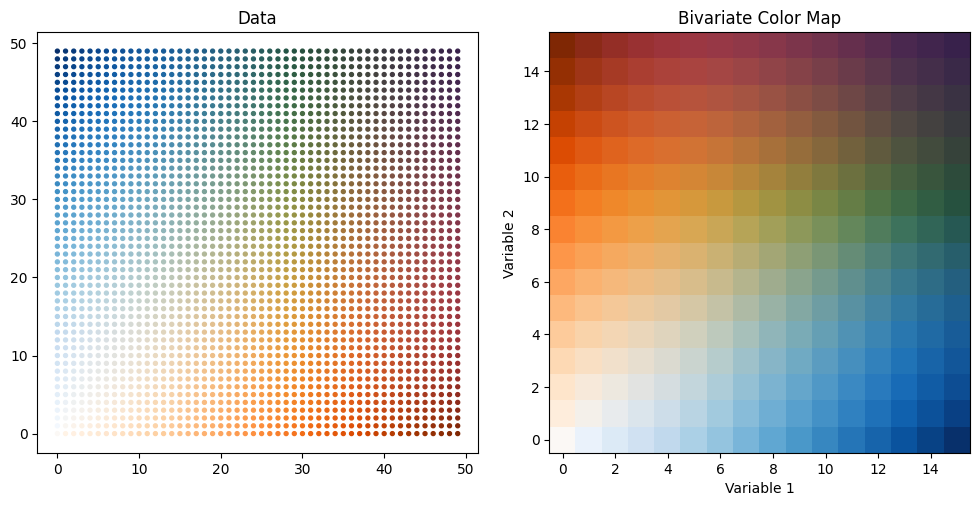

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import mixbox


# https://gist.github.com/wolfiex/64d2faa495f8f0e1b1a68cdbdf3817f1#file-bivariate-py
def colorFromBivariateData(Z1, Z2, cmap1=plt.cm.Blues, cmap2=plt.cm.Reds, preset=False):
    if preset:
        z1mn = 0.0
        z2mn = 0.0
        z1mx = 1.0
        z2mx = 1.0
    else:
        z1mn = Z1.min()
        z2mn = Z2.min()
        z1mx = Z1.max()
        z2mx = Z2.max()

    # Rescale values to fit into colormap range (0->255)
    Z1_plot = np.array((Z1 - z1mn) / (z1mx - z1mn))
    Z2_plot = np.array((Z2 - z2mn) / (z2mx - z2mn))

    Z1_color = cmap1((255 * Z1_plot).astype(np.int32))
    Z2_color = cmap2((255 * Z2_plot).astype(np.int32))

    Z_color = np.zeros_like(Z1_color)

    # Color for each point
    it = np.nditer(
        np.zeros(Z_color.shape[:-1]), flags=["multi_index"], op_flags=["readwrite"]
    )
    while not it.finished:
        # Z_color[it.multi_index] = mixbox.lerp(Z1_color[it.multi_index] * 255, Z2_color[it.multi_index] * 255, 0.5)
        divider = Z1_plot[it.multi_index] + Z2_plot[it.multi_index]
        Z_color[it.multi_index] = mixbox.lerp(
            Z1_color[it.multi_index] * 255,
            Z2_color[it.multi_index] * 255,
            # 0.5,
            Z2_plot[it.multi_index] / divider if divider > 0 else 0.5,
        )
        it.iternext()

    return Z_color / 255


xx, yy = np.mgrid[0:50, 0:50]
C_map = colorFromBivariateData(xx, yy, cmap1=plt.cm.Oranges, cmap2=plt.cm.Blues)

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
x = xx.flatten()
y = yy.flatten()
cflat = C_map.reshape((len(x), 4))
plt.scatter(x, y, c=cflat, s=8)

ax1.set_title("Data")

xx, yy = np.mgrid[0:16, 0:16]
C_map = colorFromBivariateData(xx, yy, cmap1=plt.cm.Oranges, cmap2=plt.cm.Blues)

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(C_map)
ax2.set_title("Bivariate Color Map")
ax2.set_xlabel("Variable 1")
ax2.set_ylabel("Variable 2")
ax2.set_ylim((-0.5, 0.5 + (yy.max() - yy.min())))

fig.tight_layout()
fig.show()

In [ ]:
from mapclassify import 

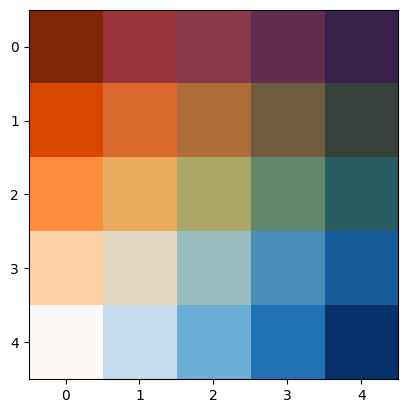

In [187]:
from matplotlib.colors import rgb2hex
from folium.plugins import FloatImage
# import cv2

import base64
from PIL import Image


col_a = "morning_starts"
# col_a = "afternoon_starts"
# col_a = "morning_ends"

col_b = "morning_ends"
# col_b = "afternoon_ends"
# col_b = "afternoon_starts"

cmap = colorFromBivariateData(
    h3_with_trips[col_a],
    h3_with_trips[col_b],
    cmap1=plt.cm.Oranges,
    cmap2=plt.cm.Blues,
)
hex_values = [rgb2hex(cmap[i, :]) for i in range(cmap.shape[0])]

color_dict = dict(zip(h3_with_trips.index, hex_values))

# h3_with_trips.reset_index().explore(
#     "index",
#     cmap=lambda x: color_dict[x],
#     legend=False,
# )

# m = h3_with_trips.reset_index().explore(
#     "index", cmap=lambda x: color_dict[x], legend=False, tiles="CartoDB Positron"
# )

default_grid_size = 5
current_grid_size = 5
# current_grid_size = 5
xx, yy = np.mgrid[0:current_grid_size, 0:current_grid_size]
C_map = colorFromBivariateData(xx, yy, cmap1=plt.cm.Oranges, cmap2=plt.cm.Blues)

img = Image.fromarray(np.uint8((C_map)[:, :, :3] * 255))

img = img.transpose(Image.FLIP_TOP_BOTTOM) #.resize((100, 100), resample=0)

plt.imshow(img)


# plt.imshow(img, interpolation='nearest')

# processed_string = base64.b64encode(C_map)

# # _, imagebytes = cv2.imencode('.jpg', C_map)

# url = (
#     "https://dataplace-assets-new.s3.eu-central-1.amazonaws.com/dataplace_logo.svg"
# )

# FloatImage(url, width="250px").add_to(m)

# m
# # C_map[:, :, :3]
# img

# import io


# def pillow_image_to_base64_string(img):
#     buffered = io.BytesIO()
#     img.save(buffered, format="PNG")
#     return base64.b64encode(buffered.getvalue()).decode("utf-8")


# data_url = "data:image/png;base64," + pillow_image_to_base64_string(img)
# # contents

# FloatImage(data_url, bottom=8, left=2, width="100px").add_to(m)
# m
# # data_url



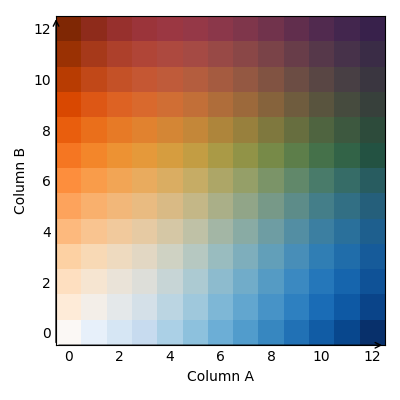

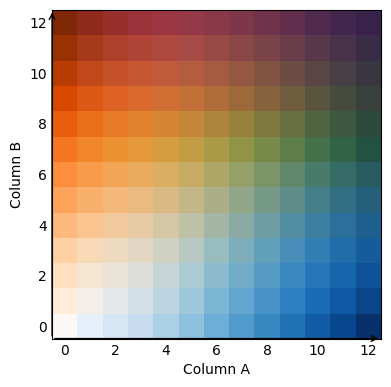


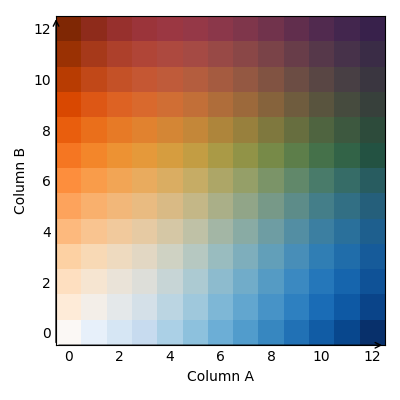

In [239]:
default_grid_size = 5
current_grid_size = 13
# current_grid_size = 5
xx, yy = np.mgrid[0:current_grid_size, 0:current_grid_size]
C_map = colorFromBivariateData(xx, yy, cmap1=plt.cm.Oranges, cmap2=plt.cm.Blues)

img = Image.fromarray(np.uint8((C_map)[:, :, :3] * 255))

# img = img.transpose(Image.FLIP_TOP_BOTTOM)  # .resize((100, 100), resample=0)

figure_size_px = 200
dpi = 100


fig, ax = plt.subplots(
    figsize=((figure_size_px * 2) / dpi, (figure_size_px * 2) / dpi), dpi=dpi
)
ax.imshow(img, origin="lower")
ax.tick_params(axis="both", which="both", length=0)
# ax.axis("off")

# fig.tight_layout()

ax.annotate(
    "",
    xy=(0, 1),
    xytext=(0, 0),
    arrowprops=dict(arrowstyle="->", lw=1),
    xycoords="axes fraction",
)
ax.annotate(
    "",
    xy=(1, 0),
    xytext=(0, 0),
    arrowprops=dict(arrowstyle="->", lw=1),
    xycoords="axes fraction",
)

ax.set_ylabel("Column B")
ax.set_xlabel("Column A")


# plt.show()


def figure_to_base64_string(plt_fig):
    import io

    buffered = io.BytesIO()
    # img.save(buffered, format="PNG")
    plt_fig.tight_layout()
    plt_fig.savefig(buffered, transparent=True, dpi=100)
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


# fig.savefig('temp.png', transparent=True)

m = h3_with_trips.reset_index().explore(
    "index", cmap=lambda x: color_dict[x], legend=False, tiles="CartoDB Positron"
)
data_url = "data:image/png;base64," + figure_to_base64_string(fig)
print(data_url)

FloatImage(data_url, bottom=8, left=2, width=f"{figure_size_px}px").add_to(m)

plt.show()
m

In [102]:
import folium

folium.__version__

'0.20.0'

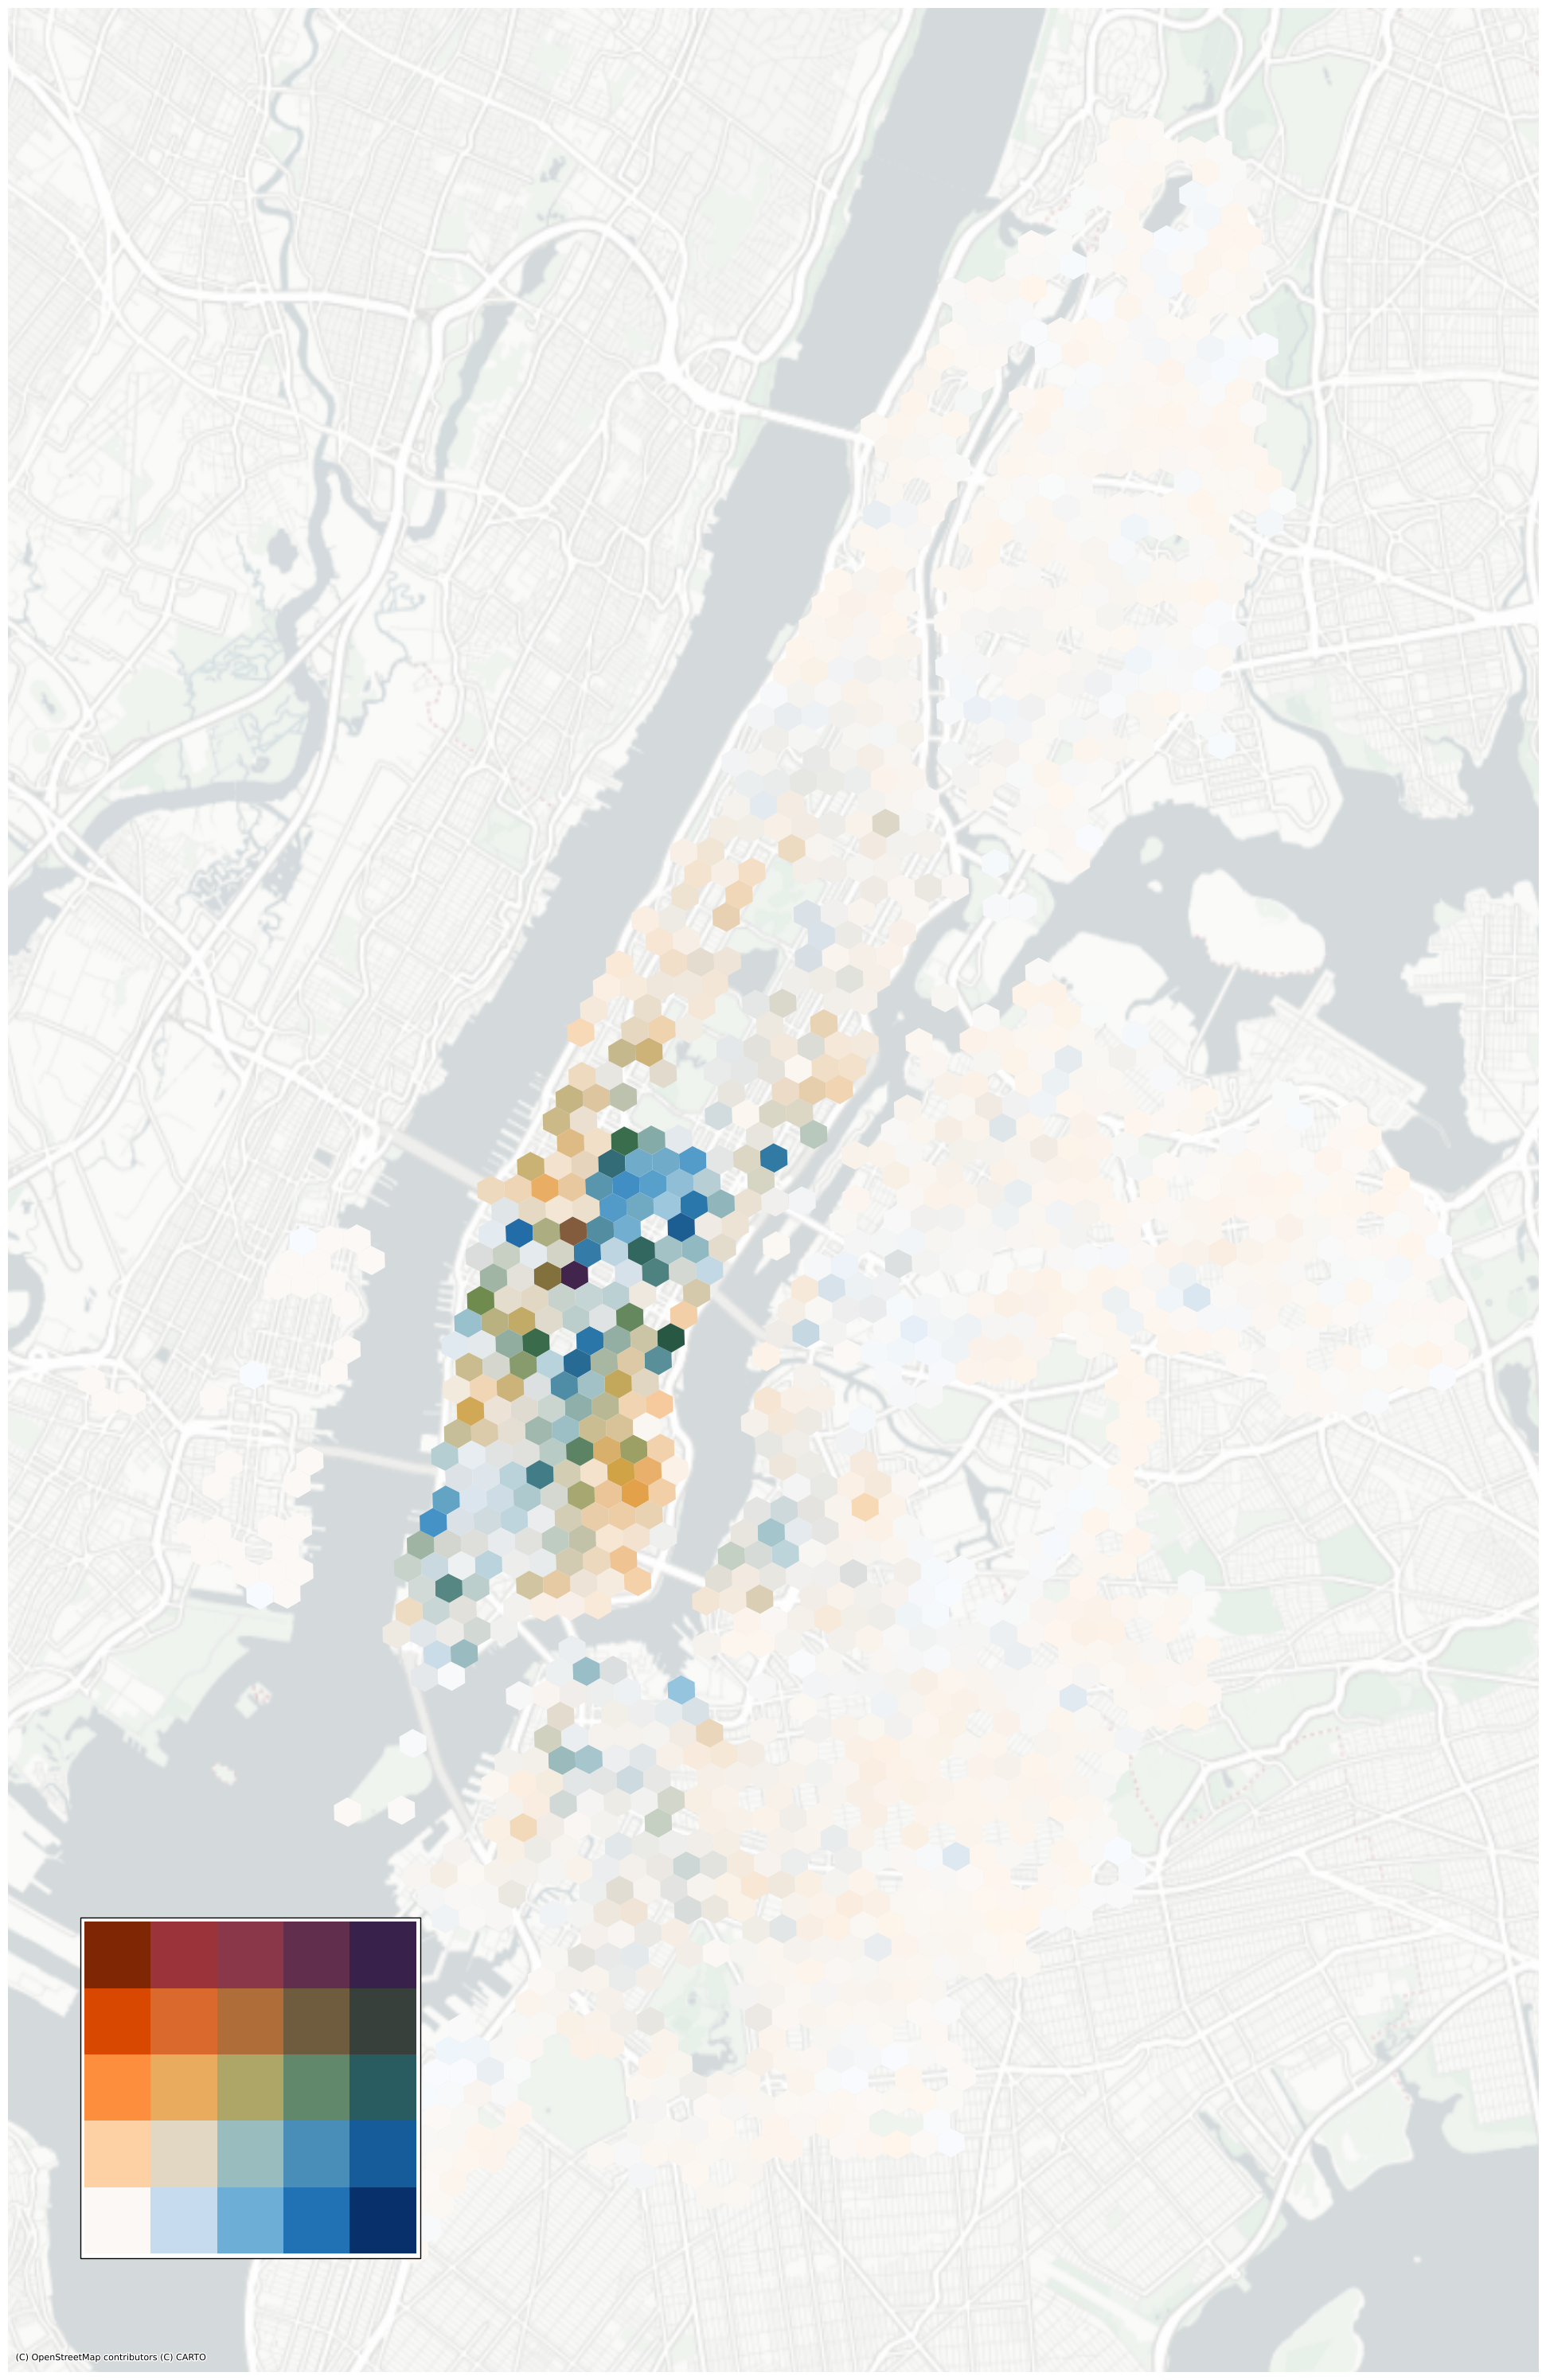

In [ ]:
import contextily as cx
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

col_a = "morning_starts"
# col_a = "afternoon_starts"
# col_a = "morning_ends"

col_b = "morning_ends"
# col_b = "afternoon_ends"
# col_b = "afternoon_starts"

cmap = colorFromBivariateData(
    h3_with_trips[col_a],
    h3_with_trips[col_b],
    cmap1=plt.cm.Oranges,
    cmap2=plt.cm.Blues,
)

base_fig_size = 20
fig_size = 30
fig, ax = plt.subplots(1, 1, figsize=(fig_size, fig_size))
# fig, ax = plt.subplots(1, 1, figsize=(20, 20))
h3_with_trips.plot(
    color=cmap,
    ax=ax,
    # alpha=np.sqrt(
    #     np.maximum(
    #         h3_with_trips[col_a] / h3_with_trips[col_a].max(),
    #         h3_with_trips[col_b] / h3_with_trips[col_b].max(),
    #     )
    # ),
    # alpha=np.maximum(
    #         h3_with_trips[col_a] / h3_with_trips[col_a].max(),
    #         h3_with_trips[col_b] / h3_with_trips[col_b].max(),
    #     ),
)
# h3_with_trips.boundary.plot(ax=ax, color="k")
# gpd.GeoSeries([h3_with_trips.union_all().boundary], crs=h3_with_trips.crs).plot(ax=ax, color="k")
cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs=4326)

default_grid_size = 5
# current_grid_size = 256
current_grid_size = 5
xx, yy = np.mgrid[0:current_grid_size, 0:current_grid_size]
C_map = colorFromBivariateData(xx, yy, cmap1=plt.cm.Oranges, cmap2=plt.cm.Blues)


# res 20
# image_box = OffsetImage(C_map, zoom=40, origin="lower")
# anno_box = AnnotationBbox(
#     image_box,
#     xy=(0.05, 0.05),
#     xycoords="axes fraction",
#     box_alignment=(0, 0),
#     frameon=True,
#     # bboxprops={"edgecolor": "black", "alpha": 1},
# )
# ax.add_artist(anno_box)

# # fig_text(x=0.19, y=0.14, s="More night traffic →", ax=ax, fig=fig, fontsize=18)
# fig.text(
#     x=0.183,
#     y=0.132,
#     s="More night traffic →",
#     fontsize=20,
#     # fontweight="ultralight",
#     verticalalignment="center",
#     # fontfamily="DejaVu Sans",
# )
# fig.text(
#     x=0.16,
#     y=0.215,
#     rotation=90,
#     s="More day traffic →",
#     fontsize=20,
#     # fontweight="ultralight",
#     verticalalignment="center",
#     # fontfamily="DejaVu Sans",
# )

image_box = OffsetImage(
    C_map,
    zoom=40 * (fig_size / base_fig_size) / (current_grid_size / default_grid_size),
    origin="lower",
)
anno_box = AnnotationBbox(
    image_box,
    xy=(0.05, 0.05),
    xycoords="axes fraction",
    box_alignment=(0, 0),
    frameon=True,
    # bboxprops={"edgecolor": "black", "alpha": 1},
)
ax.add_artist(anno_box)

# fig_text(x=0.19, y=0.14, s="More night traffic →", ax=ax, fig=fig, fontsize=18)
# fig.text(
#     x=0.183,
#     y=0.132,
#     s="More night traffic →",
#     fontsize=20 * fig_size / base_fig_size,
#     # fontweight="ultralight",
#     verticalalignment="center",
#     # fontfamily="DejaVu Sans",
# )
# fig.text(
#     x=0.16,
#     y=0.215,
#     rotation=90,
#     s="More day traffic →",
#     fontsize=20 * fig_size / base_fig_size,
#     # fontweight="ultralight",
#     verticalalignment="center",
#     # fontfamily="DejaVu Sans",
# )

# image_box = OffsetImage(img, zoom=0.275 * fig_size / base_fig_size, origin="upper")
# anno_box = AnnotationBbox(
#     image_box,
#     xy=(0.97, 0.97),
#     xycoords="axes fraction",
#     box_alignment=(1, 1),
#     frameon=False,
# )
# ax.add_artist(anno_box)

# fig.text(
#     x=0.605,
#     y=0.76,
#     s="Warsaw movement data",
#     fontsize=30 * fig_size / base_fig_size,
#     # fontweight="ultralight",
#     verticalalignment="center",
#     horizontalalignment="left",
#     # fontfamily="DejaVu Sans",
# )

# fig.text(
#     x=0.605,
#     y=0.74,
#     s="Activity across the day\nMarch and April 2024 data\nWorking days only",
#     fontsize=20 * fig_size / base_fig_size,
#     # fontweight="ultralight",
#     verticalalignment="top",
#     horizontalalignment="left",
#     # fontfamily="DejaVu Sans",
# )

# fig.text(
#     x=0.87,
#     y=0.12,
#     s="Author: Kamil Raczycki",
#     fontsize=15 * fig_size / base_fig_size,
#     # fontweight="ultralight",
#     verticalalignment="bottom",
#     horizontalalignment="right",
#     # fontfamily="DejaVu Sans",
# )

ax.set_axis_off()
plt.tight_layout()

In [76]:
np.sqrt(0.001)

0.03162277660168379

<Axes: >

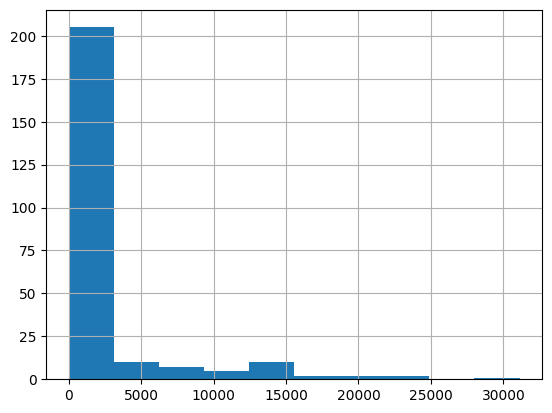

In [71]:
morning_summed_trips.hist()

<Axes: >

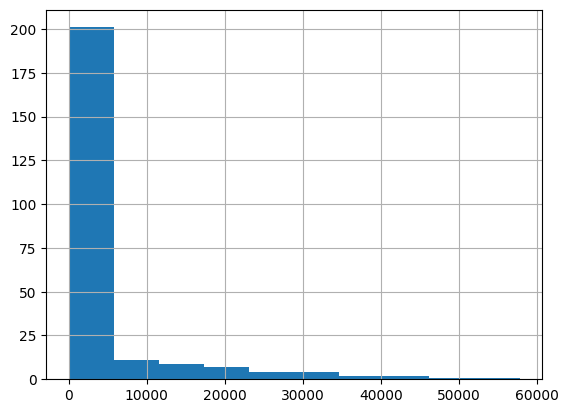

In [72]:
afternoon_summed_trips.hist()

In [67]:
zones.merge(
    summed_trips.reset_index(),
    left_on="locationid",
    right_on="PULocationID",
).explore("count", tiles="CartoDB Voyager")

In [65]:
zones.merge(
    summed_trips.reset_index(),
    left_on="locationid",
    right_on="PULocationID",
).explore("count", tiles="CartoDB Voyager")